# **Libraries:**

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# **Importing Dataset:**

In [ ]:
from google.colab import drive#connecting to google drive where the data is saved
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/data/train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))#reading the train images

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/data/train/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-847_jpg.rf.89bd720c4b70e1849de2f973a021015c.jpg
/content/drive/MyDrive/data/train/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-542_jpg.rf.182e4a44f8170b22648799195fe0b060.jpg
/content/drive/MyDrive/data/train/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-569_jpg.rf.f01864e0d2af224a78b312b4b189d86f.jpg
/content/drive/MyDrive/data/train/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-600_jpg.rf.7010854068a9bbc5eb14fb9ebd6c934b.jpg
/content/drive/MyDrive/data/train/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-110_jpg.rf.abfc5441ecdbac6e38c4c712aa08a70e.jpg
/content/drive/MyDrive/data/train/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-192_jpg.rf.be062ceb793c1ec8b755510030e7e2dc.jpg
/content/drive/MyDrive/data/train/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-998_jpg.rf.3cdb66a1977dd1569c269a3cee9b4b6f.jpg
/content/drive/MyDrive/data/train/gB_10_s2_2019-

In [ ]:
# Define the path to the folder containing training images
train_images_path = '/content/drive/MyDrive/data/train'

# Define the path to the annotation text file, which contains bounding box and class information for each image
annotation_file_path = '/content/drive/MyDrive/data/train/_annotations.txt'

# A dictionary to map class IDs to their respective class names
class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

# Initialize an empty dictionary to store annotations for each image
annotations = {}

# Open the annotation file and process each line
with open(annotation_file_path, 'r') as f:
    for line in f:
        # Split the line into parts based on whitespace
        parts = line.strip().split()

        # Check if the line has fewer than 2 parts; if so, skip it
        if len(parts) < 2:
            print(f'skipping due to the incorrect format: {line}')
            continue

        # The first part is the image name
        image_name = parts[0]

        # The second part contains bounding box information and class ID, separated by commas
        bbox_and_class = parts[1].split(',')

        # Check if the bounding box and class information has fewer than 5 values; if so, skip the line
        if len(bbox_and_class) < 5:
            print(f"Skipping the line due to missing bounding box or class info: {line}")
            continue

        # Extract the class ID, which is the last value in bbox_and_class
        class_id = int(bbox_and_class[-1])

        # Store the class ID in the annotations dictionary, using the image name as the key
        annotations[image_name] = class_id


skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.f0ab9d03d718ac287cac6fca394783d0.jpg

skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.fa7c39ef44d869bdab6c298c89442f19.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.4a274f58e714facd11a3693a3325c3d5.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.c507475339c83c2de42f2400987923d2.jpg



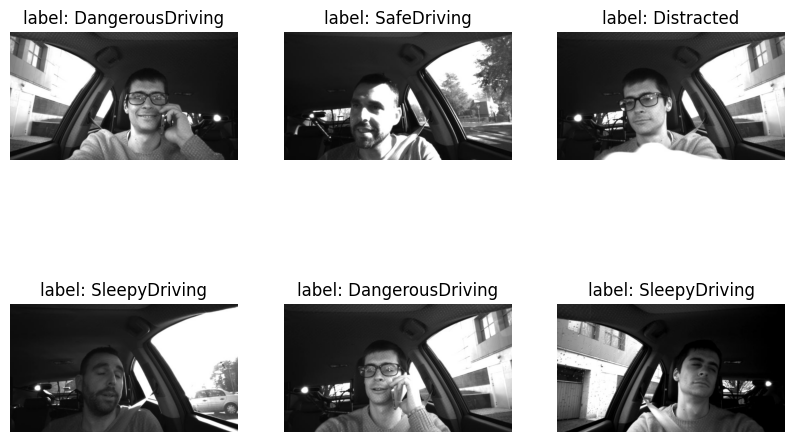

In [ ]:
# Define a function to load an image and its corresponding label
def load_image_and_label(image_name):
    # Construct the full path to the image file
    img_path = os.path.join(train_images_path, image_name)

    # Read the image using OpenCV
    img = cv2.imread(img_path)

    # Convert the image from BGR (OpenCV default) to RGB color space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Check if the image name exists in the annotations dictionary
    if image_name in annotations:
        # Retrieve the class ID from the annotations dictionary
        class_id = annotations[image_name]
        # Return the image and its corresponding class label
        return img, class_names[class_id]
    else:
        # If no label is found for the image, print a warning and return a placeholder label
        print(f'Warning: No label found for {image_name}')
        return img, "No label"

# Create a figure to display the images with their labels
plt.figure(figsize=(10, 10))

# List the first 6 image files from the training images directory
image_files = os.listdir(train_images_path)[:6]

# Loop through the selected image files
for i, image_file in enumerate(image_files):
    # Load the image and its label using the defined function
    img, label = load_image_and_label(image_file)

    # Create a subplot for the current image
    ax = plt.subplot(3, 3, i + 1)

    # Display the image on the subplot
    plt.imshow(img)

    # Set the title of the subplot to the corresponding label
    plt.title(f'label: {label}')

    # Turn off the axis for better visualization
    plt.axis('off')

# Show the plotted images with their labels
plt.show()


In [ ]:
def process_images_and_labels(image_dict, train_images_path):
    images = []  # List to store processed images.
    labels = []  # List to store corresponding labels.

    # Loop through each image name and its associated label in the provided dictionary.
    for image_name, label in image_dict.items():
        # Construct the full image path by combining the base path with the image name.
        img_path = os.path.join(train_images_path, image_name)

        # Check if the image file exists at the constructed path.
        if not os.path.exists(img_path):
            print(f"Warning: {img_path} does not exist. Skipping...")  # Warn if the image does not exist.
            continue  # Skip to the next image if the current one is missing.

        # Read the image using OpenCV.
        img = cv2.imread(img_path)
        # Convert the image to grayscale.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Resize the image to a fixed size of 128x128 pixels.
        img = cv2.resize(img, (128, 128))
        # Normalize the pixel values to the range [0, 1].
        img = img / 255.0
        # Convert the image to a float32 data type and add it to the images list.
        images.append(img.astype(np.float32))
        # Add the corresponding label to the labels list.
        labels.append(label)

    # Return the processed images and labels as a tuple.
    return images, labels

# Call the function to process images and labels using the provided annotations and training path.
images, labels = process_images_and_labels(annotations, train_images_path)


In [ ]:
from collections import Counter
frequency = Counter(labels)
print("Frequencies:", dict(frequency))

Frequencies: {3: 4969, 2: 347, 0: 3732, 1: 1676, 4: 785, 5: 439}


In [ ]:
def add_noise(image):

    # Generate random noise from a normal distribution with mean=0 and std=25.
    noise = np.random.normal(0, 25, image.shape).astype(image.dtype)
    # Add the noise to the image using OpenCV.
    noisy_image = cv2.add(image, noise)
    return noisy_image

def blur_image(image, kernel_size=(5, 5)):

    # Use OpenCV to apply Gaussian blur with the specified kernel size.
    return cv2.GaussianBlur(image, kernel_size, 0)

def flip_image(image, mode='horizontal'):

    if mode == 'horizontal':
        return cv2.flip(image, 1)  # Flip horizontally.
    elif mode == 'vertical':
        return cv2.flip(image, 0)  # Flip vertically.
    else:
        raise ValueError("Mode should be 'horizontal' or 'vertical'")  # Raise an error for invalid modes.

def augment_class_data(images, labels, target_classes, augmentations):

    augmented_images = []  # List to store augmented images.
    augmented_labels = []  # List to store corresponding labels.

    # Loop through each image and its corresponding label.
    for img, label in zip(images, labels):
        # Add the original image and label to the augmented data.
        augmented_images.append(img)
        augmented_labels.append(label)

        # Check if the label is in the target classes for augmentation.
        if label in target_classes:
            # Apply each augmentation function to the image.
            for aug in augmentations:
                augmented_img = aug(img)  # Apply the augmentation.
                augmented_images.append(augmented_img)  # Add the augmented image to the list.
                augmented_labels.append(label)  # Add the corresponding label.

    # Return the augmented images and labels.
    return augmented_images, augmented_labels


# Specify the classes to augment.
target_classes = [2, 4, 5]

# Define the augmentation functions to apply.
augmentations = [lambda img: flip_image(img, 'horizontal'),  # Horizontal flip.
                 lambda img: flip_image(img, 'vertical'),    # Vertical flip.
                 add_noise,                                 # Add random noise.
                 blur_image]                                # Apply Gaussian blur.

# Augment the dataset for the target classes.
augmented_images, augmented_labels = augment_class_data(images, labels, target_classes, augmentations)

# Print the size of the original and augmented datasets.
print(f"Original dataset size: {len(images)}")
print(f"Augmented dataset size: {len(augmented_images)}")


Original dataset size: 11948
Augmented dataset size: 18232


In [ ]:

X = np.array(augmented_images)
y = np.array(augmented_labels)

X = X.reshape(-1, 128, 128, 1)

In [ ]:

frequency = Counter(augmented_labels)
print("Frequencies:", dict(frequency))

Frequencies: {3: 4969, 2: 1735, 0: 3732, 1: 1676, 4: 3925, 5: 2195}


In [ ]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured for TensorFlow.")
    except RuntimeError as e:
        print(e)


#CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),# convert the 2d output of the conv2d to 1d array or vector
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,748,934 (10.49 MB)

 Trainable params: 2,748,934 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X, y,
                epochs=10,
                batch_size=32,
                validation_split=0.10)

Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.3737 - loss: 1.7646 - val_accuracy: 0.7155 - val_loss: 0.6832
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - accuracy: 0.7321 - loss: 0.6672 - val_accuracy: 0.7708 - val_loss: 0.5733
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - accuracy: 0.8042 - loss: 0.4966 - val_accuracy: 0.8399 - val_loss: 0.4297
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.8496 - loss: 0.3801 - val_accuracy: 0.8580 - val_loss: 0.3709
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.8775 - loss: 0.3092 - val_accuracy: 0.8569 - val_loss: 0.3840
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.8897 - loss: 0.2757 - val_accuracy: 0.8602 - val_loss: 0.3501
Epoch 7/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.9021 - loss: 0.2426 - val_accuracy: 0.8783 - val_loss: 0.3343
Epoch 8/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.9083 - loss: 0.2213 - val_accu

In [ ]:
test_images_path = '/content/drive/MyDrive/data/valid'
annotation_file_test = '/content/drive/MyDrive/data/valid/_annotations.txt'

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

annotations_test = {}

with open(annotation_file_test, 'r') as f:
    for line in f:
        parts = line.strip().split()

        if len(parts) < 2:
            print(f'skipping due to the incorrect format: {line}')
            continue

        image_name = parts[0]

        bbox_and_class = parts[1].split(',')

        if len(bbox_and_class) <5:
            print(f"Skipping the line due to missing bouding box or class info: {line}")
            continue

        class_id = int(bbox_and_class[-1])

        annotations_test[image_name] = class_id

In [ ]:
def process_images_and_labels(image_dict, test_images_path):

    images_test = []
    labels_test= []

    for image_name, label in image_dict.items():
        img_path = os.path.join(test_images_path, image_name)

        if not os.path.exists(img_path):
            print(f"Warning: {img_path} does not exist. Skipping...")
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        images_test.append(img.astype(np.float32))
        labels_test.append(label)

    return images_test, labels_test

images, labels = process_images_and_labels(annotations_test, test_images_path)

In [ ]:
X_test = np.array(images)
y_test = np.array(labels)

X_test = X_test.reshape(-1, 128, 128, 1)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 434ms/step - accuracy: 0.9177 - loss: 0.3352


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(y_test, y_pred)
print(report)


61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       609
           1       0.87      0.73      0.80       252
           2       0.94      0.91      0.93        56
           3       0.88      0.97      0.92       799
           4       0.91      0.78      0.84       125
           5       0.96      0.98      0.97        81

    accuracy                           0.92      1922
   macro avg       0.93      0.89      0.90      1922
weighted avg       0.92      0.92      0.92      1922

